In [49]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

plt.rcParams['figure.figsize'] = (10,5)
sns.set(style="whitegrid")


# Chargement des données préparées

In [50]:
df = pd.read_excel('online_retail_II.xlsx')

# Fiche synthétique des données

In [51]:
df['InvoiceDate'].min(), df['InvoiceDate'].max()
df.nunique()

Invoice        28816
StockCode       4632
Description     4681
Quantity         825
InvoiceDate    25296
Price           1606
Customer ID     4383
Country           40
dtype: int64

In [52]:
dico = pd.DataFrame({
    "Variable": df.columns,
    "Type": df.dtypes.values,
    "Nb valeurs uniques": df.nunique().values,
    "% manquants": df.isna().mean().round(4).values,
    "Exemple": df.iloc[0].values
})

dico



,Variable,Type,Nb valeurs uniques,% manquants,Exemple
0,Invoice,object,28816,0.0000,489434
1,StockCode,object,4632,0.0000,85048
2,Description,object,4681,0.0056,15CM CHRISTMAS GLASS BALL 20 LIGHTS
3,Quantity,int64,825,0.0000,12
4,InvoiceDate,datetime64[ns],25296,0.0000,2009-12-01 07:45:00
5,Price,float64,1606,0.0000,6.95
6,Customer ID,float64,4383,0.2054,13085.0
7,Country,object,40,0.0000,United Kingdom


# Qualité des données

In [53]:
df.isna().sum()
df.duplicated().sum()
df['Invoice'].astype(str).str.startswith('C').sum()


np.int64(10206)

# Feature Engineering minimal

In [54]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['InvoiceMonth'] = df['InvoiceDate'].dt.to_period('M').dt.to_timestamp()

df['InvoiceTotal'] = df['Quantity'] * df['Price']

df['is_return'] = df['Invoice'].astype(str).str.startswith('C')


# Graphique 1 — Distribution du montant des transactions

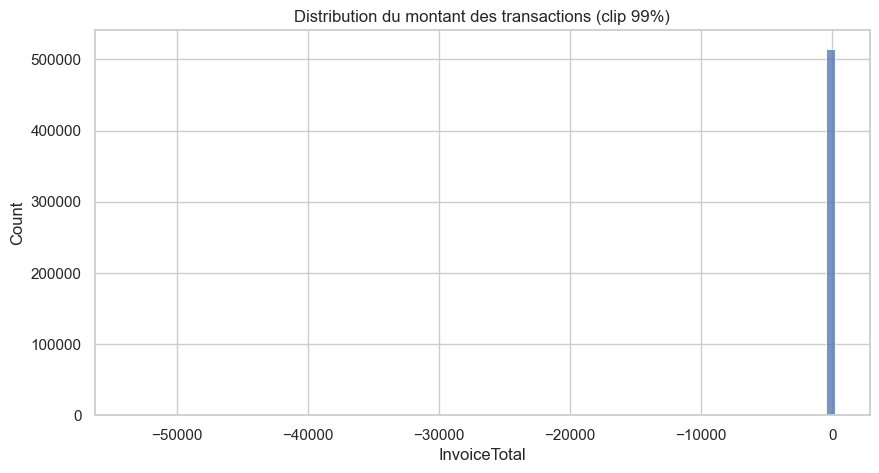

In [55]:
sns.histplot(
    df.loc[~df['is_return'], 'InvoiceTotal'].clip(upper=df['InvoiceTotal'].quantile(0.99)),
    bins=80
)
plt.title("Distribution du montant des transactions (clip 99%)")
plt.savefig("Distribution du montant des transactions (clip 99%).png", dpi=300, bbox_inches="tight")
plt.show()


La distribution est très asymétrique : la grande majorité des transactions est de faible montant, tandis qu’une petite proportion de commandes très élevées crée une longue queue à droite.

# Graphique 2 — Distribution des quantités commandées

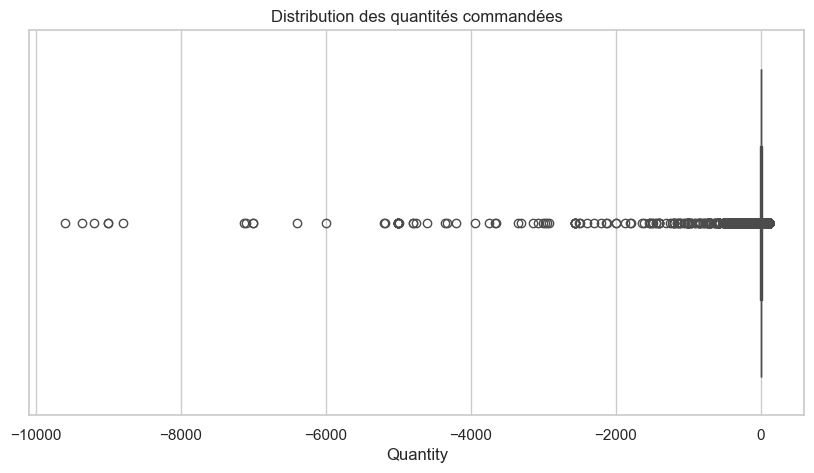

In [56]:
sns.boxplot(x=df['Quantity'].clip(upper=df['Quantity'].quantile(0.99)))
plt.title("Distribution des quantités commandées")
plt.savefig("Distribution des quantités commandées.png", dpi=300, bbox_inches="tight")
plt.show()


On observe beaucoup de commandes avec de petites quantités, et quelques valeurs extrêmes lorsqu’un client achète en gros. La distribution est fortement concentrée autour des faibles volumes.

# Graphique 3 — Série temporelle du CA mensuel

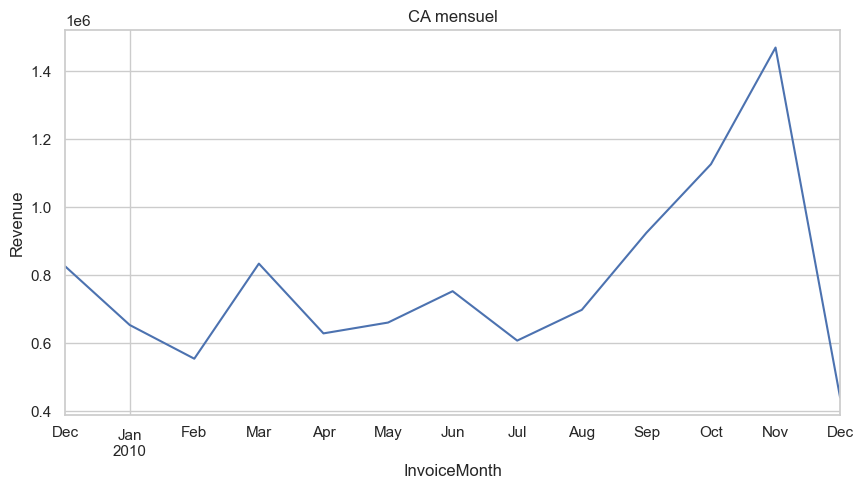

In [57]:
monthly = df.loc[~df['is_return']].groupby('InvoiceMonth')['InvoiceTotal'].sum()
monthly.plot()
plt.title("CA mensuel")
plt.ylabel("Revenue")
plt.savefig("CA mensuel.png", dpi=300, bbox_inches="tight")


Le revenu mensuel suit une tendance irrégulière, avec des périodes de hausse marquée et des creux distincts, possiblement liés à la saisonnalité.

# Graphique 4 — Série temporelle du nombre de transactions

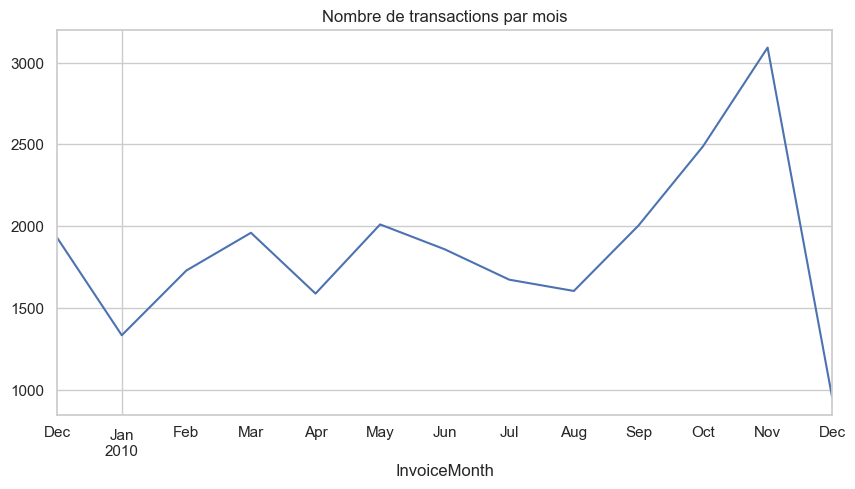

In [58]:
tx_count = df.loc[~df['is_return']].groupby('InvoiceMonth')['Invoice'].nunique()
tx_count.plot()
plt.title("Nombre de transactions par mois")
plt.savefig("Nombre de transactions par mois.png", dpi=300, bbox_inches="tight")


Le volume de transactions suit une dynamique similaire au CA, mais avec parfois des décalages : nombreux petits achats n’impliquent pas toujours une hausse du CA.

# Graphique 5 — Matrice de corrélation

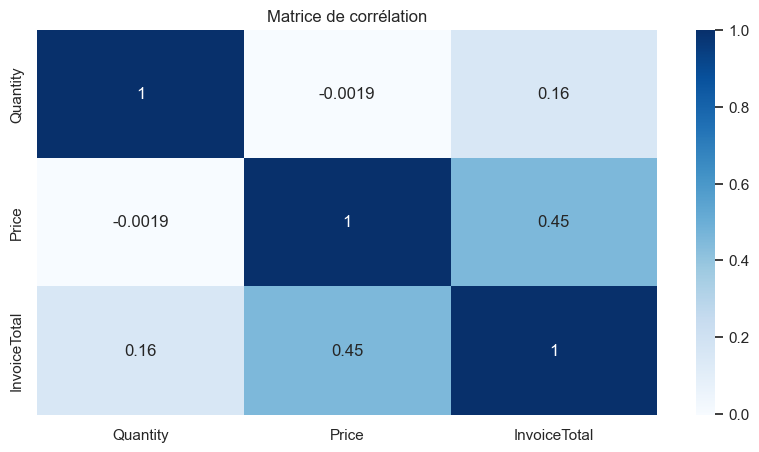

In [59]:
corr = df[['Quantity','Price','InvoiceTotal']].corr()
sns.heatmap(corr, annot=True, cmap="Blues")
plt.title("Matrice de corrélation")
plt.savefig("Matrice de corrélation.png", dpi=300, bbox_inches="tight")


InvoiceTotal est logiquement corrélé à Quantity, tandis que Price montre une corrélation plus faible avec les autres variables.

# Graphique 6 — Top 10 produits par CA

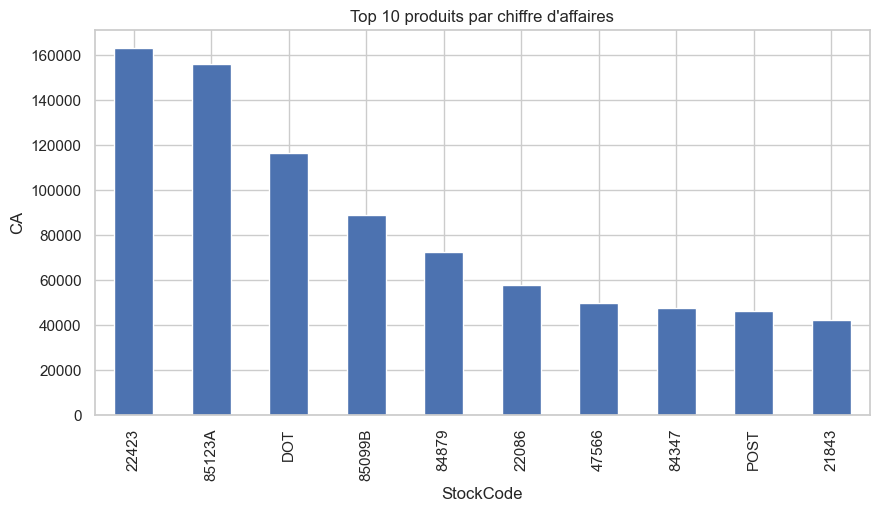

In [60]:
top_products = df.groupby('StockCode')['InvoiceTotal'].sum().nlargest(10)
top_products.plot(kind='bar')
plt.title("Top 10 produits par chiffre d'affaires")
plt.ylabel("CA")
plt.savefig("Top 10 produits par chiffre d'affaires.png", dpi=300, bbox_inches="tight")


Quelques produits dominent largement les ventes, signalant une forte concentration du CA.

# Graphique 7 — Heatmap CA × Pays

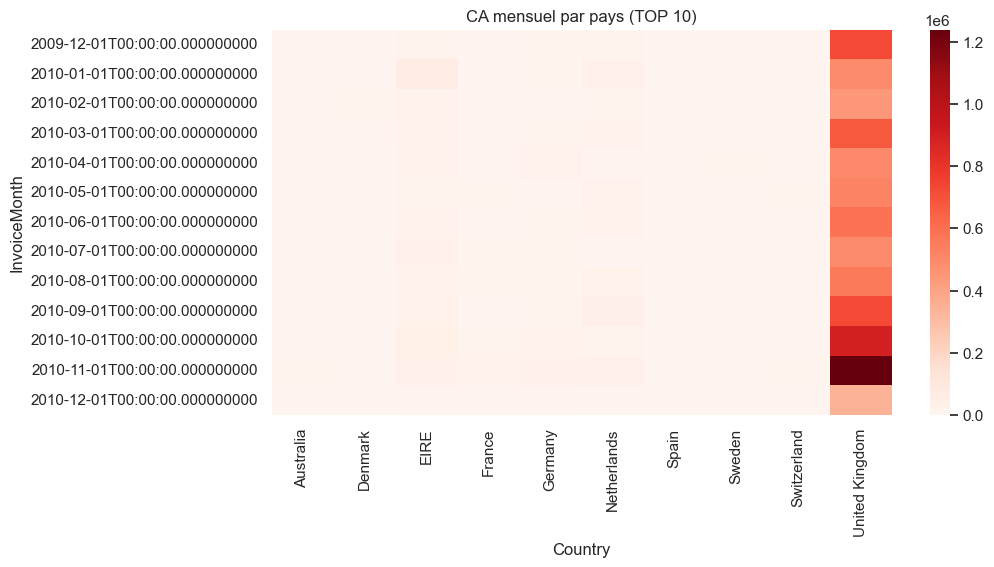

In [61]:
top_countries = df.groupby('Country')['InvoiceTotal'].sum().nlargest(10).index
tmp = df[df['Country'].isin(top_countries)]

pivot = tmp.pivot_table(
    index='InvoiceMonth',
    columns='Country',
    values='InvoiceTotal',
    aggfunc='sum'
)

sns.heatmap(pivot.fillna(0), cmap="Reds")
plt.title("CA mensuel par pays (TOP 10)")
plt.savefig("CA mensuel par pays (TOP 10).png", dpi=300, bbox_inches="tight")



Certains pays représentent une part importante du CA et montrent des variations saisonnières plus marquées que d'autres.

# Graphique 8 — Scatterplot Quantity vs Price

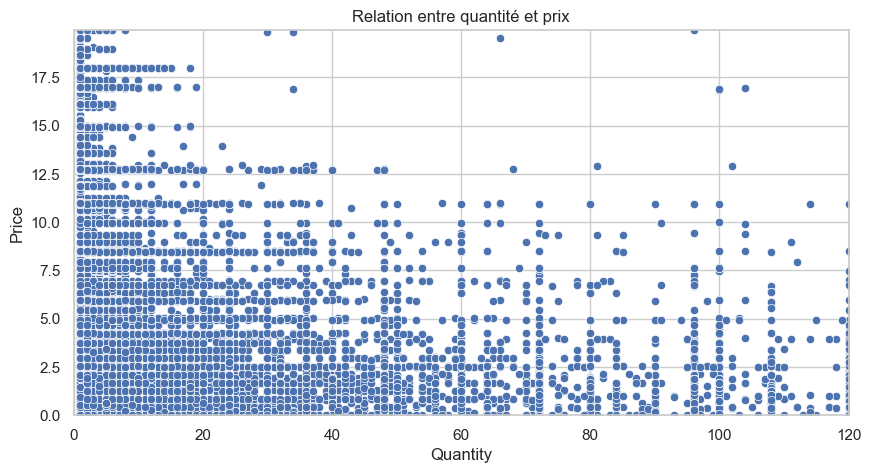

In [62]:
sns.scatterplot(
    data=df.loc[~df['is_return']],
    x='Quantity',
    y='Price'
)
plt.title("Relation entre quantité et prix")
plt.xlim(0, df['Quantity'].quantile(0.99))
plt.ylim(0, df['Price'].quantile(0.99))
plt.savefig("Relation entre quantité et prix.png", dpi=300, bbox_inches="tight")



La majorité des points se concentre autour de quantités faibles et prix bas. On ne voit pas de relation claire entre quantité et prix.

# Recommandations pour l’application Streamlit

### Filtres à prévoir

Période : mois, trimestre, année

Pays (multi-sélection)

Exclure retours

Filtre montant (min/max)

Filtre quantité (min/max)

### Visualisations à intégrer

Séries temporelles CA + transactions

Histogrammes & boxplots (avec log-scale)

Bar charts triables

Heatmap pays × CA

Scatterplots interactifs

### Fonctionnalités UX

Tooltips explicatifs

Téléchargement des figures en PNG

Export des données filtrées en CSV

Badge “Retours exclus”

Highlight automatique des outliers

Indicateur "Top produits"